# Complete Working Example

In this example we use the `CausalForest` class from `cforest` to fit a model on data. With the fitted model we predict effects on new data and visualize these predictions. On top we showcase how one can save and load a fitted model.

In [18]:
import numpy as np
from pandas.testing import assert_frame_equal
from cforest.forest import CausalForest

In [19]:
from example import simulate
from example import plot_treatment_effect
from example import plot_predicted_treatment_effect

%matplotlib inline

## Data

Here we use simulated data. For the sake of simplicity we chose a very simple data generating process using the [Neyman-Rubin potential outcome framework](https://en.wikipedia.org/wiki/Rubin_causal_model).

### Treatment effect:

In the Neyman-Rubin potential outcome framework we postulate the existence of so-called potential outcomes.
That is, for the outcome we want to measure we assume that, in theory, an individual $i$ has a (potential) outcome if it were not treated, which we call $y_i^0$, and a (potential) outcome if it were treated, which we call $y_i^1$.
These potential outcomes exist no matter if the individual was actually treated or not.
In reality we only observe one outcome, namely $y_i$; however, if the individual was treated we get $y_i = y_i^1$ and otherwise $y_i = y_i^0$.

The (individual) **treatment effect** is defined by $\tau_i = y_i^1 - y_i^0$, which again cannot be computed since at least one potential outcome is unobservable.
In the following we assume that the treatment effect is a smooth function which depends on two covariates and our goal will be to estimate this function. Analytically we can write the treatment effect function as
$$
\tau(x_1, x_2) = \gamma \left[1 + \exp(-\alpha \, (x_1 - 1/3))\right]^{-1} \left[1 + \exp(-\alpha \, (x_2 - 1/3))\right]^{-1} \,,
$$
which (using $\gamma = 5$ and $\alpha = 0.9$) looks as

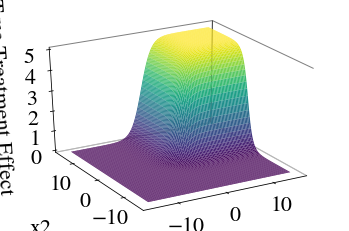

In [20]:
plot_treatment_effect(alpha=0.9, scale=5, figsize=(14, 10))

### Simulation strategy:

For (independent) individuals $i=1,\dots,n$ do:

1. Simulate (independent) covariates: $x_{i1}, x_{i2} \sim \mathrm{U}(-15, 15)$
2. Simulate error terms: $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$
3. Compute untreated potential outcome: $y_i^0 = 0.5 + 0.1 x_{i1} - 0.1 x_{i2} + \epsilon_i$
4. Compute treated potential outcome: $y_i^1 = y_i^0 + \tau(x_{i1}, x_{i2})$
5. Simulate treatment status: $T_i \sim \mathrm{Bern}(0.5)$
6. Compute (observed) outcomes: $y_i = T_i y_i^1 + (1 - T_i) y_i^0$
7. **Return**: Outcomes $y_i$, covariates $x_i = (x_{i1}, x_{i2})$ and treatment status $T_i$.

### Create the data:

In [21]:
params = {
    'nobs': 5000,
    'nfeatures': 2,
    'coefficients': [0.5, 0.1, -0.1],
    'error_var': 0.1,
    'seed': 1,
    'alpha': 0.9,
}

X, t, y = simulate(**params)

## Estimation (fitting)

### Initiate a Causal Forest estimator:

In [22]:
forestparams = {
    'num_trees': 25,
    'ratio_features_at_split': 1,
}

treeparams = {
    'min_leaf': 5,
    'max_depth': 20,
}

cf = CausalForest(forestparams, treeparams, seed_counter=1)

### Fit the model onto the training data:

In [23]:
cf = cf.fit(X, t, y)

## Prediction

### Predict treatment effects for newly observed covariates:

In [24]:
newx = np.array([
    [5, -10],
    [-10, 5],
    [-10, -10],
    [5, 5],
    [10, 10]
])

predictions = cf.predict(newx)
predictions

array([-0.15676054,  0.14265838,  0.08804082,  4.98777584,  4.96462603])

### Visualize the predicted surface:

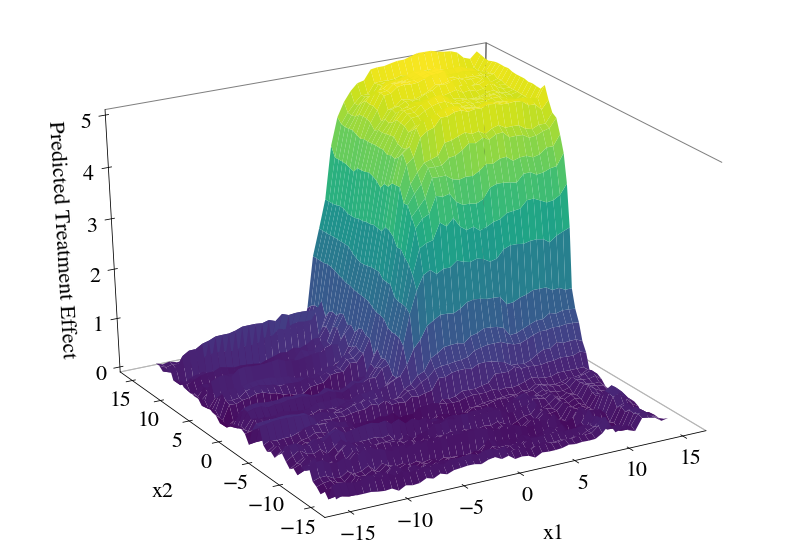

In [25]:
plot_predicted_treatment_effect(cf, figsize=(14, 10), npoints=50)

## Saving the Model

To save a (fitted) estimator model we simply call the `save` method with the filename.

In [26]:
cf.save(filename="fitted-example-model.csv", overwrite=True)

## Loading a Fitted Model

To load a model we have to iniate a new CausalForest object or use an old one and overwrite the fitted_model their. Here we iniate a new one, load the model which we just saved and assert that the stored models in the two estimators are equal.

In [27]:
cff = CausalForest(forestparams, treeparams)
cff = cff.load("fitted-example-model.csv")

assert_frame_equal(cff.fitted_model, cf.fitted_model)